# Practice Assignment: Understanding Distributions Through Sampling

** *This assignment is optional, and I encourage you to share your solutions with me and your peers in the discussion forums!* **


To complete this assignment, create a code cell that:
* Creates a number of subplots using the `pyplot subplots` or `matplotlib gridspec` functionality.
* Creates an animation, pulling between 100 and 1000 samples from each of the random variables (`x1`, `x2`, `x3`, `x4`) for each plot and plotting this as we did in the lecture on animation.
* **Bonus:** Go above and beyond and "wow" your classmates (and me!) by looking into matplotlib widgets and adding a widget which allows for parameterization of the distributions behind the sampling animations.


Tips:
* Before you start, think about the different ways you can create this visualization to be as interesting and effective as possible.
* Take a look at the histograms below to get an idea of what the random variables look like, as well as their positioning with respect to one another. This is just a guide, so be creative in how you lay things out!
* Try to keep the length of your animation reasonable (roughly between 10 and 30 seconds).

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
%matplotlib notebook

<IPython.core.display.Javascript object>


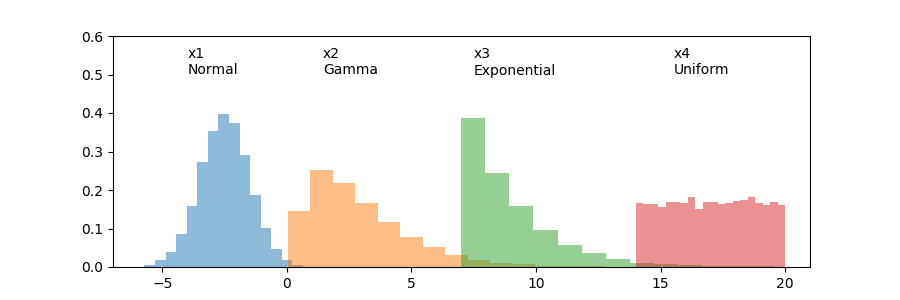

In [4]:
# generate 4 random variables from the random, gamma, exponential, and uniform distributions
x1 = np.random.normal(-2.5, 1, 10000)
x2 = np.random.gamma(2, 1.5, 10000)
x3 = np.random.exponential(2, 10000)+7
x4 = np.random.uniform(14,20, 10000)

# plot the histograms
plt.figure(figsize=(9,3))
plt.hist(x1, normed=True, bins=20, alpha=0.5)
plt.hist(x2, normed=True, bins=20, alpha=0.5)
plt.hist(x3, normed=True, bins=20, alpha=0.5)
plt.hist(x4, normed=True, bins=20, alpha=0.5);
plt.axis([-7,21,0,0.6])

plt.text(x1.mean()-1.5, 0.5, 'x1\nNormal')
plt.text(x2.mean()-1.5, 0.5, 'x2\nGamma')
plt.text(x3.mean()-1.5, 0.5, 'x3\nExponential')
plt.text(x4.mean()-1.5, 0.5, 'x4\nUniform')

In [11]:
#pyplot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
axs = [ax1, ax2, ax3, ax4]
ttl = ["Normal", "Gamma", "Exponential", "Uniform"]
data = [x1, x2, x3, x4]
for i in range(0, len(axs)):
    axs[i].hist(data[i], normed = True, bins = 20, alpha = 0.5)
    axs[i].set_title(ttl[i])

<IPython.core.display.Javascript object>

In [7]:
import matplotlib.gridspec as gridspec

# Setup plot figure and frames
plt.figure(figsize=(9,5))
gspec = gridspec.GridSpec(3,3)
tl_histogram = plt.subplot(gspec[0,0])
tr_boxplot = plt.subplot(gspec[0,1:])
bl_histogram = plt.subplot(gspec[1:,0])
br_scatterplot = plt.subplot(gspec[1:,1:])

# Send data
n = 1000
x1s = x1[np.random.randint(0,len(x1),size=(n))]
x2s = x2[np.random.randint(0,len(x3),size=(n))]
x3s = x3[np.random.randint(0,len(x3),size=(n))]
x4s = x4[np.random.randint(0,len(x4),size=(n))]

tl_histogram.hist(x1s, bins = 100, normed = True)
tr_boxplot.boxplot(x1s, x2s)
bl_histogram.hist(x2s, bins = 100, normed = True)
br_scatterplot.scatter(x3s, x4s)

# Pretify


<IPython.core.display.Javascript object>

TypeError: 'SubplotSpec' object does not support indexing

<IPython.core.display.Javascript object>


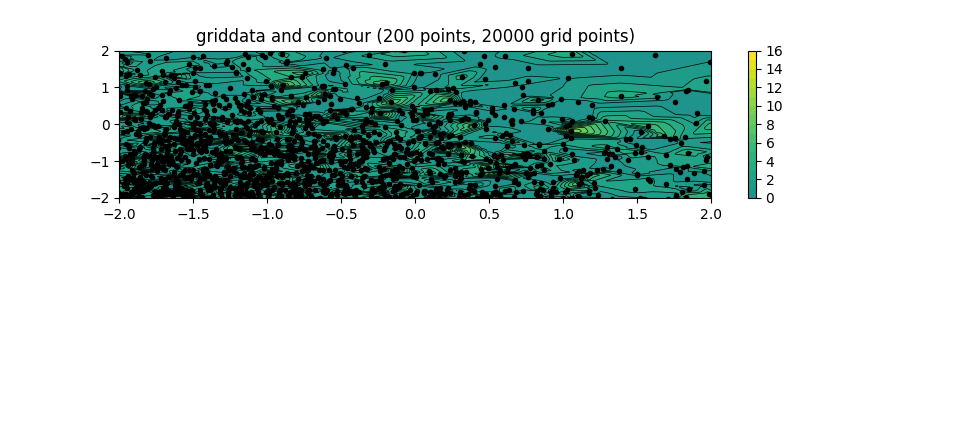

griddata and contour: 0.484131 seconds


In [7]:
# Inspired by https://matplotlib.org/gallery/images_contours_and_fields/tricontour_vs_griddata.html#sphx-glr-gallery-images-contours-and-fields-tricontour-vs-griddata-py
import matplotlib.tri as tri
import matplotlib.mlab as mlab
import time

plt.figure(figsize=(9,3))
gspec = gridspec.GridSpec(1,1)

# Obtain Data
x = np.random.normal(-2.5, 2, 10000)
y = np.random.normal(-2.5, 2, 10000)
z = np.random.exponential(2, 10000)

np.random.seed(0)
npts = 200
ngridx = 100
ngridy = 200

# griddata and contour.
start = time.clock()
plt.subplot(2,1,1)
xi = np.linspace(-2.1, 2.1, ngridx)
yi = np.linspace(-2.1, 2.1, ngridy)
zi = mlab.griddata(x, y, z, xi, yi, interp='linear')
plt.contour(xi, yi, zi, 15, linewidths=0.5, colors='k')
plt.contourf(xi, yi, zi, 15, norm=plt.Normalize(vmax=abs(zi).max(), vmin=-abs(zi).max()))
plt.colorbar()  # draw colorbar
plt.plot(x, y, 'ko', ms=3)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.title('griddata and contour (%d points, %d grid points)' %
          (npts, ngridx * ngridy))
print('griddata and contour: %f seconds' % (time.clock() - start))
plt.show()

<IPython.core.display.Javascript object>


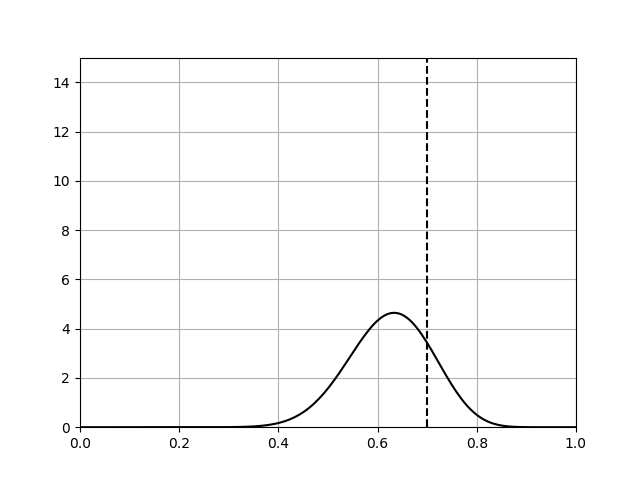

In [8]:
"""
================
The Bayes update
================

This animation displays the posterior estimate updates as it is refitted when
new data arrives.
The vertical line represents the theoretical value to which the plotted
distribution should converge.
"""

# update a distribution based on new data.
import scipy.stats as ss
from matplotlib.animation import FuncAnimation


class UpdateDist(object):
    def __init__(self, ax, prob=0.5):
        self.success = 0
        self.prob = prob
        self.line, = ax.plot([], [], 'k-')
        self.x = np.linspace(0, 1, 200)
        self.ax = ax

        # Set up plot parameters
        self.ax.set_xlim(0, 1)
        self.ax.set_ylim(0, 15)
        self.ax.grid(True)

        # This vertical line represents the theoretical value, to
        # which the plotted distribution should converge.
        self.ax.axvline(prob, linestyle='--', color='black')

    def init(self):
        self.success = 0
        self.line.set_data([], [])
        return self.line,

    def __call__(self, i):
        # This way the plot can continuously run and we just keep
        # watching new realizations of the process
        if i == 0:
            return self.init()

        # Choose success based on exceed a threshold with a uniform pick
        if np.random.rand(1,) < self.prob:
            self.success += 1
        y = ss.beta.pdf(self.x, self.success + 1, (i - self.success) + 1)
        self.line.set_data(self.x, y)
        return self.line,

fig, ax = plt.subplots()
ud = UpdateDist(ax, prob=0.7)
anim = FuncAnimation(fig, ud, frames=np.arange(100), init_func=ud.init,
                     interval=100, blit=True)
plt.show()